In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import pickle
import joblib
import gzip

from statsmodels.tsa.stattools import adfuller

In [2]:
#Set some global plot defaults
sns.set(rc={"figure.figsize": (10, 8), 'legend.fontsize': 18}) # figsize and leg fontsize of seaborn plots
plt.rc('axes',  labelsize=18)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('axes',  titlesize=18)                                  # fontsize of the title

In [3]:
#
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=12, center=False).mean()
    rolstd = pd.Series.rolling(timeseries, window=12, center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 

In [4]:
#read it in
with gzip.GzipFile('data/cleaned_df.pkl.gz', 'r') as file:  
    df = joblib.load(file)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546126 entries, 0 to 546125
Data columns (total 24 columns):
Opened                  546126 non-null datetime64[ns]
Category                546126 non-null object
Supervisor_District     546126 non-null float64
Police_District         546126 non-null object
Latitude                546126 non-null float64
Longitude               546126 non-null float64
Source                  546126 non-null object
Has_Media_Link          546126 non-null bool
Tract                   546126 non-null float64
Poverty                 546126 non-null float64
Income                  546126 non-null float64
Unemployment            546126 non-null float64
Population              546126 non-null float64
Percent_Male            546126 non-null float64
Percent_Pop_0_14        546126 non-null float64
Percent_Pop_15_24       546126 non-null float64
Percent_Pop_25_64       546126 non-null float64
Percent_Pop_65_up       546126 non-null float64
Percent_Pop_White       

In [6]:
df.sample(5)

,Opened,Category,Supervisor_District,Police_District,Latitude,Longitude,Source,Has_Media_Link,Tract,Poverty,...,Percent_Pop_0_14,Percent_Pop_15_24,Percent_Pop_25_64,Percent_Pop_65_up,Percent_Pop_White,Percent_Pop_Black,Percent_Pop_Hispanic,Percent_Pop_Asian,Percent_Pop_Other,Is_Closed
99409,2015-10-20 02:12:25,Street and Sidewalk Cleaning,9.0,MISSION,37.75732,-122.4134,Web,True,228.01,8.1,...,0.156120,0.062903,0.712391,0.068587,0.399773,0.023873,0.358469,0.159341,0.058545,True
368331,2017-03-31 08:43:50,Street and Sidewalk Cleaning,3.0,CENTRAL,37.78647,-122.4082,Mobile/Open311,False,123.01,29.6,...,0.111010,0.108269,0.554591,0.226131,0.267702,0.079032,0.330288,0.272727,0.050251,True
323677,2017-01-11 04:26:13,Homeless Concerns,9.0,MISSION,37.77005,-122.4207,Mobile/Open311,True,201.00,12.8,...,0.079040,0.066790,0.755328,0.098842,0.274543,0.044806,0.467360,0.158416,0.054875,True
297157,2016-11-21 03:19:27,Street and Sidewalk Cleaning,9.0,MISSION,37.76074,-122.4184,Mobile/Open311,False,208.00,4.2,...,0.073427,0.092339,0.724571,0.109663,0.334711,0.021456,0.421488,0.158137,0.064209,True
65235,2015-07-13 09:54:32,Graffiti,9.0,MISSION,37.75793,-122.4124,Mobile/Open311,True,228.01,8.1,...,0.156120,0.062903,0.712391,0.068587,0.399773,0.023873,0.358469,0.159341,0.058545,True


## Resample per week and count the 8 categories

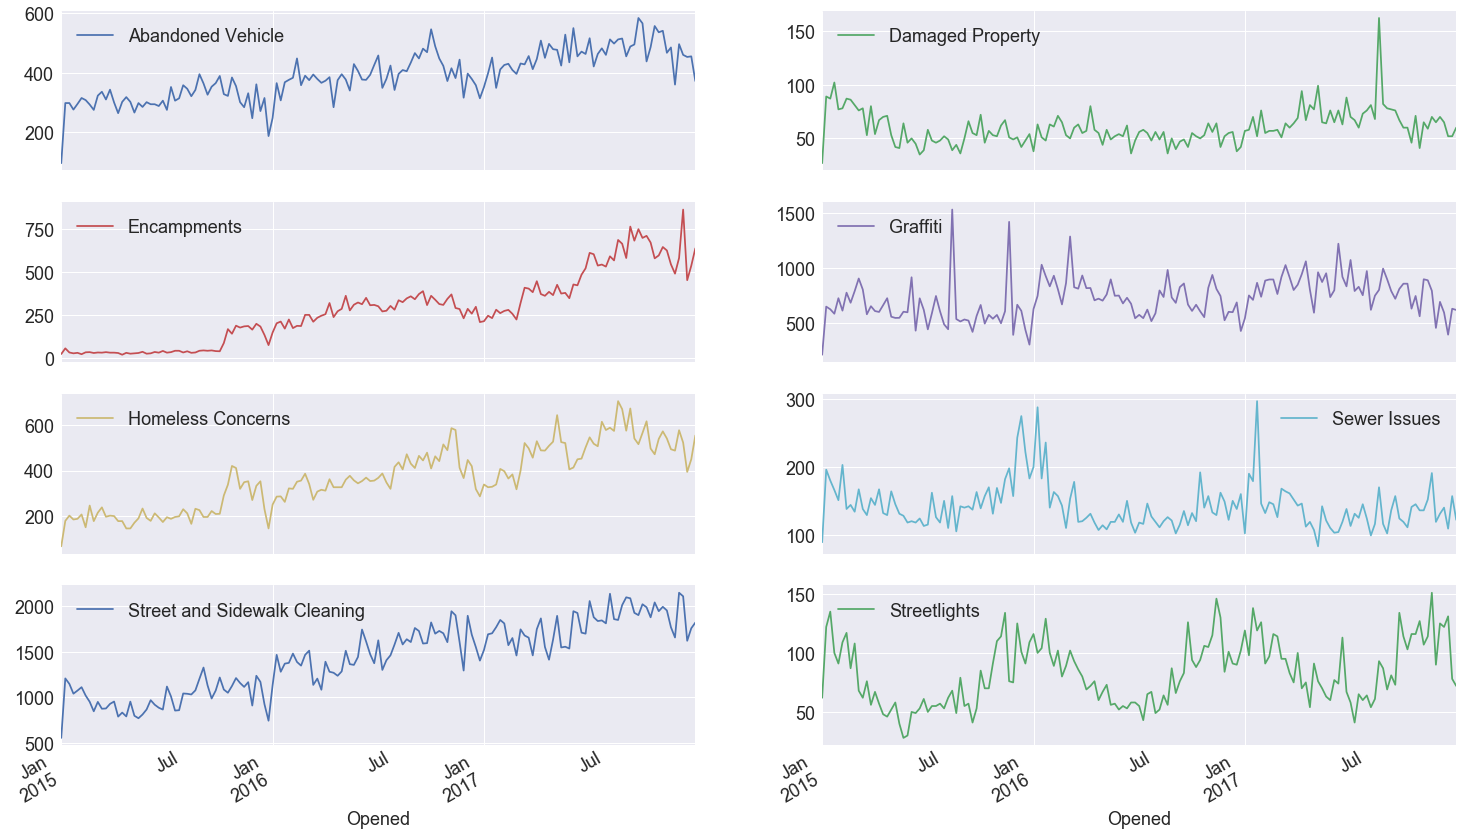

In [7]:
ts = df.copy()
ts = ts[['Opened', 'Category']]
ts.set_index('Opened', inplace=True)
ts = pd.get_dummies(ts['Category'])

ts.resample('W').sum().plot(subplots=True, figsize=(25, 15), layout=(4, 2), sharey=False)
plt.show()

## Focus on graffiti requests

In [8]:
graffiti_w = ts.resample('W').sum()['Graffiti']

In [9]:
graffiti_w.sample(15)

Opened
2017-07-02    1072.0
2016-11-27     528.0
2015-04-19     664.0
2015-11-22    1416.0
2016-02-21     671.0
2016-05-15     897.0
2016-07-31     591.0
2015-07-26     609.0
2015-08-30     517.0
2016-03-13     826.0
2016-04-17     708.0
2016-11-13     811.0
2015-03-29     655.0
2017-07-09     792.0
2017-07-30     972.0
Name: Graffiti, dtype: float64

## Decompose graffiti 

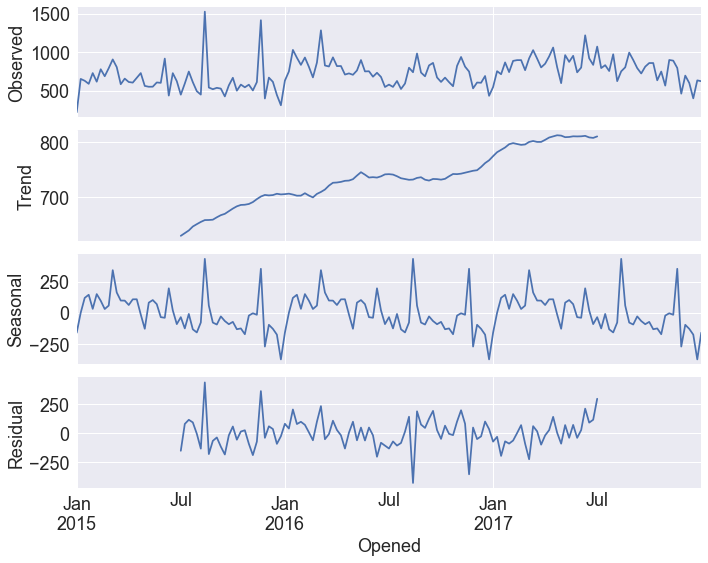

In [10]:
decomposition = sm.tsa.seasonal_decompose(graffiti_w)
decomposition.plot()
plt.show()

## Test stationarity of graffiti

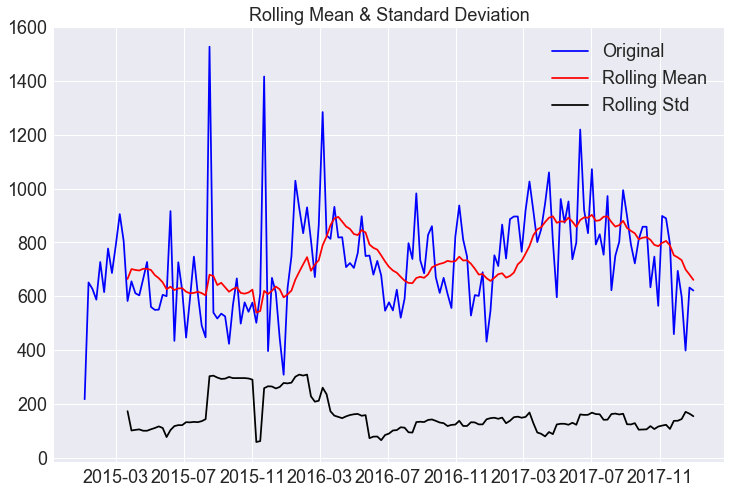

Results of Dickey-Fuller Test:
Test Statistic                  -4.009720
p-value                          0.001360
#Lags Used                       3.000000
Number of Observations Used    153.000000
Critical Value (5%)             -2.880623
Critical Value (1%)             -3.473830
Critical Value (10%)            -2.576945
dtype: float64


In [11]:
test_stationarity(graffiti_w)

## Test it with first difference

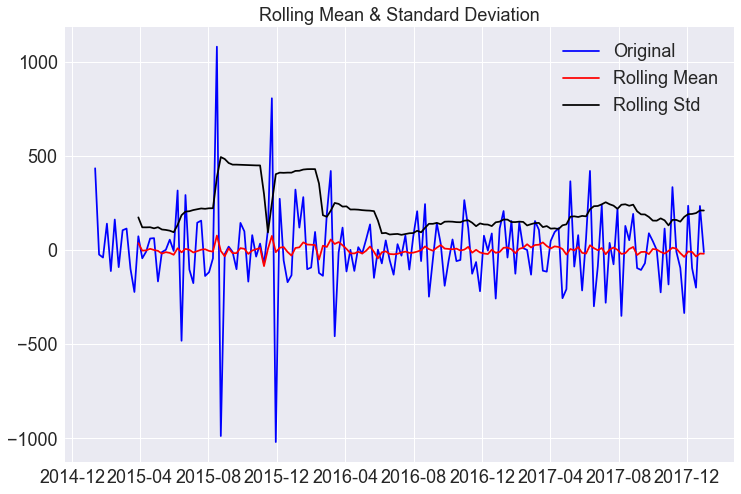

Results of Dickey-Fuller Test:
Test Statistic                -7.560985e+00
p-value                        3.010595e-11
#Lags Used                     6.000000e+00
Number of Observations Used    1.490000e+02
Critical Value (5%)           -2.881141e+00
Critical Value (1%)           -3.475018e+00
Critical Value (10%)          -2.577221e+00
dtype: float64


In [12]:
test_stationarity(graffiti_w.diff(1).dropna())

## Test it with full year difference (i.e. season)

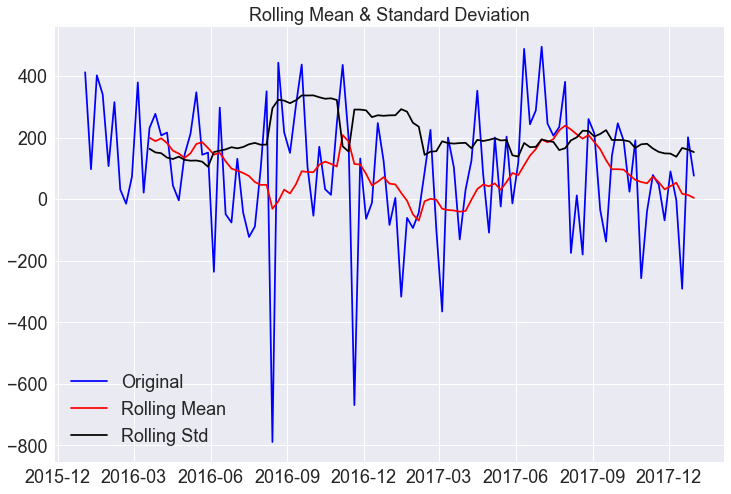

Results of Dickey-Fuller Test:
Test Statistic                -1.002809e+01
p-value                        1.611930e-17
#Lags Used                     0.000000e+00
Number of Observations Used    1.040000e+02
Critical Value (5%)           -2.889758e+00
Critical Value (1%)           -3.494850e+00
Critical Value (10%)          -2.581822e+00
dtype: float64


In [13]:
test_stationarity(graffiti_w.diff(52).dropna())

## Test it with first difference of season difference

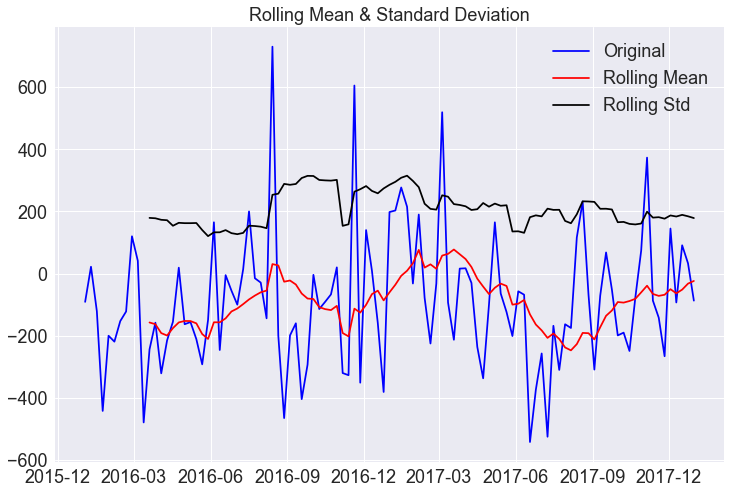

Results of Dickey-Fuller Test:
Test Statistic                -8.842157e+00
p-value                        1.657276e-14
#Lags Used                     0.000000e+00
Number of Observations Used    1.040000e+02
Critical Value (5%)           -2.889758e+00
Critical Value (1%)           -3.494850e+00
Critical Value (10%)          -2.581822e+00
dtype: float64


In [14]:
test_stationarity((graffiti_w.diff(1) - graffiti_w.diff(52)).dropna())

## Get (Partial) Autocorrelation plots

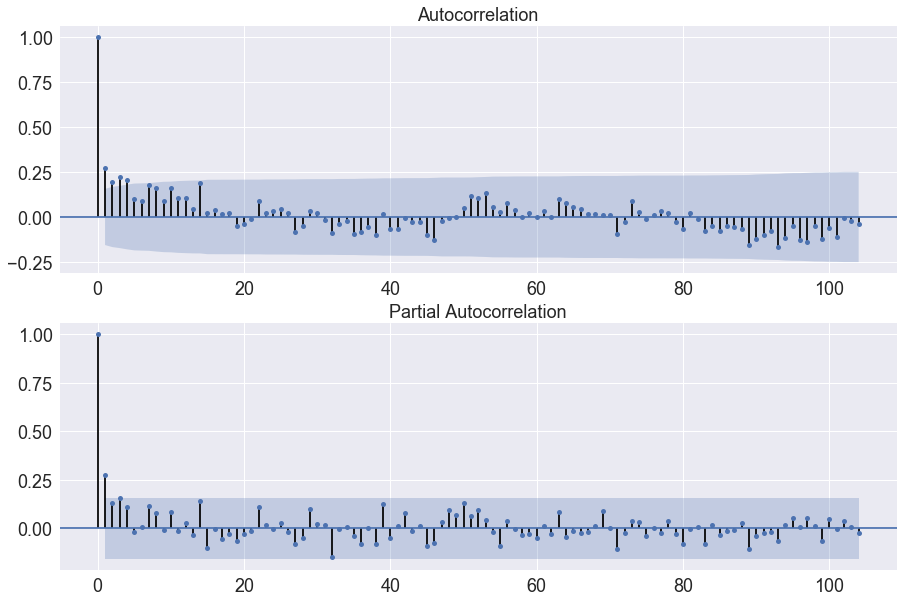

In [15]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(graffiti_w, lags=52*2, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(graffiti_w, lags=52*2, ax=ax2)
plt.show()

## Test out a SARIMA model 

In [16]:
#Stationarity tests suggest we need to difference (add seasonal difference too)
#ACF has 4-5 values above confidence interval: multiple lag terms for AR
#PACF has 1-2 values above confidence interval: few MA terms
#PCAF is positive after one season (52) -- therefore add SAR term but not SMA

mod = sm.tsa.statespace.SARIMAX(graffiti_w, order=(4,1,1), seasonal_order=(1,1,0,52))
results = mod.fit()
print results.summary()

                                 Statespace Model Results                                 
Dep. Variable:                           Graffiti   No. Observations:                  157
Model:             SARIMAX(4, 1, 1)x(1, 1, 0, 52)   Log Likelihood                -702.075
Date:                            Mon, 19 Mar 2018   AIC                           1418.150
Time:                                    16:17:09   BIC                           1439.544
Sample:                                01-04-2015   HQIC                          1426.839
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0123      0.129      0.095      0.924      -0.241       0.266
ar.L2         -0.0332      0.129   

## Plot the fit results and diagnostics of the fit

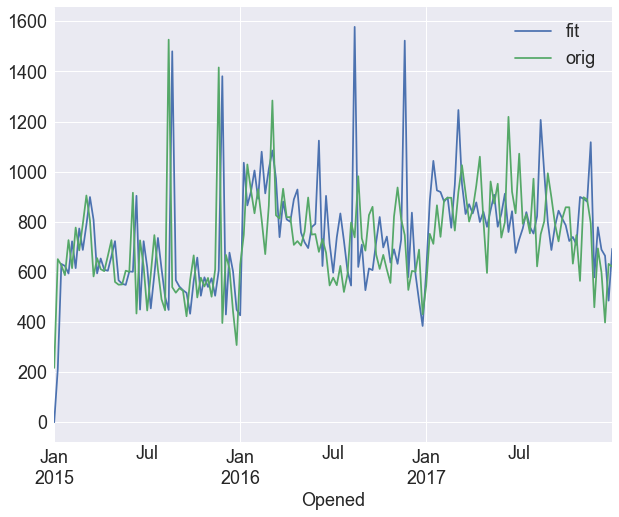

In [17]:
results.fittedvalues.plot(label='fit')
graffiti_w.plot(label='orig')
plt.legend()
plt.show()

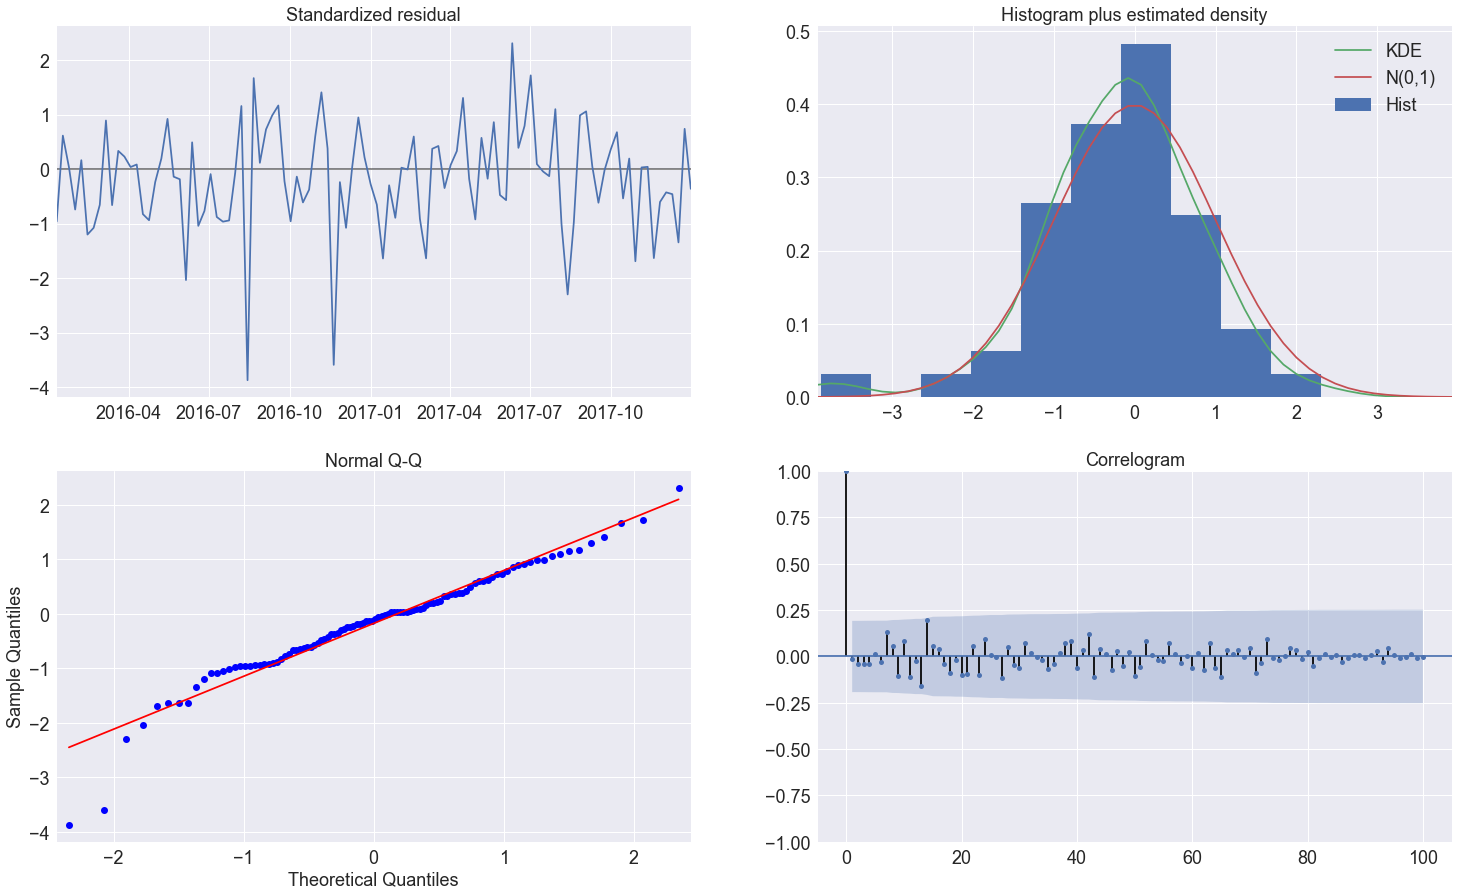

In [18]:
results.plot_diagnostics(figsize=(25,15), lags=100)
plt.show()